# Étude de l'effet du saut de propriétés à l'interface sur la conservation de l'énergie

In [1]:
import sys
import itertools
import os
from copy import deepcopy

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path
savefig_path = os.path.join(lib_path, "figures", "influence_prop/")
save_fig = True

In [2]:
from src.main import *
from src.plot_fields import *

%matplotlib widget
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)
rc("font", size=18)
rc("legend", fontsize=16)
rc("figure", max_open_warning=80)
rc("text.latex", preamble=r"\usepackage{siunitx}")

In [3]:
n_max = 10**8

## Paramètres de la simulation

Ici on va construire une grille de paramètres.

La résolution se fait à chaque fois en QUICK avec Euler explicite en temps.

In [4]:
# d = 6./100*Delta/2.
Delta = 0.02
alpha = 0.06
n_bulles = 1
rho_cp1 = 70278.0
rho_cp2 = 702780.
lda1 = 5.5 * 10**-2
lda2 = 15.5
kappa0 = lda1 / rho_cp1
Vtot = 0.005**2 * Delta

n_lim = 10**8
t_fin = 0.2


class Problem_prop(Problem):
    def __init__(self, T0, markers=None, num_prop=None, phy_prop=None):
        super().__init__(T0, markers=markers, num_prop=num_prop, phy_prop=phy_prop)

    @property
    def name(self):
        return (
            r"$\frac{\lambda_l}{\lambda_v} = %.2g,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = %.2g,\ \frac{\lambda_l}{{\rho C_p}_l} = %.2g$"
            % (
                self.phy_prop.lda1 / self.phy_prop.lda2,
                self.phy_prop.rho_cp1 / self.phy_prop.rho_cp2,
                self.phy_prop.lda1 / self.phy_prop.rho_cp1,
            )
        )

On a les 3 nombres adimensionnés suivants à faire évoluer :
- le rapport des capacités thermiques massique $\frac{{\rho C_p}_l}{{\rho C_p}_v}$, on va prendre $[0.1, 1, 10, 1000]$
- le rapport des conductivités thermiques $\frac{\lambda_l}{\lambda_v}$, on va prendre la même liste
- le coefficient $\frac{\kappa}{\kappa_0}$ avec $\kappa = \frac{\lambda_l}{{\rho C_p}_l}$, on va prendre $[0.1, 1, 10]$
- le dernier paramètre n'est pas pertinent a priori dans la résolution de l'équation. On le fera varier par rapport à $\lambda_{1_0}$ pour vérifier qu'il n'en pas influent. 

In [5]:
5.5*10**-2 / 15.5

0.0035483870967741938

In [6]:
rapp_lda = [0.001, 0.00355, 0.01, 0.1, 1.0]
rapp_rhocp = [0.001, 0.01, 0.1, 0.5, 1.]

rho_cp_v = rho_cp2
kappa_0 = lda1 / rho_cp1

num_prop_ref = NumericalProperties(
    dx=2. * 10**-5,
    schema="quick",
    time_scheme="rk3",
    Delta=Delta,
    cfl=0.5,
    fo=0.5,
)
num_prop = NumericalProperties(
    dx=3.9 * 10**-5,
    schema="quick",
    time_scheme="rk3",
    Delta=Delta,
    cfl=0.5,
    fo=0.5,
)
phy_prop = PhysicalProperties(
    Delta=Delta,
    v=0.2,
    dS=0.005**2,
    lda1=lda1,
    lda2=lda2,
    rho_cp1=rho_cp1,
    rho_cp2=rho_cp2,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
markers = Bulles(n_bulle=n_bulles, Delta=Delta, alpha=alpha)
markers.shift(0.01)

def compute_for_rapp(rapp):
    rho_cp_v = rho_cp2
    rho_cp_l = rho_cp_v * rapp[1]
    lda_l = rho_cp_l * kappa_0 * rapp[2]
    lda_v = lda_l / rapp[0]
#     rho_cp_v = rho_cp_l / rapp[1]
#     rho_cp_l = lda_l / (kappa_0 * rapp[2])
#     plot = rapp[3]
#     ax = rapp[4]
    phy_prop = PhysicalProperties(
        Delta=Delta,
        v=0.2,
        dS=0.005**2,
        lda1=lda_l,
        lda2=lda_v,
        rho_cp1=rho_cp_l,
        rho_cp2=rho_cp_v,
        diff=1.0,
        alpha=alpha,
        a_i=357.0,
    )
    phy_prop_ref = deepcopy(phy_prop)
    phy_prop_ref.v = 0.
    plot = Plotter('decale', ispretty=False)
    prob = Problem_prop(
        get_T_creneau, num_prop=num_prop, phy_prop=phy_prop, markers=markers
    )
    prob_ref = Problem_prop(
        get_T_creneau, num_prop=num_prop_ref, phy_prop=phy_prop_ref, markers=markers
    )
    t, e = prob.load_or_compute(
        t_fin=t_fin, n=min(n_max, n_lim), number_of_plots=1, plotter=plot
    )
    t, e = prob_ref.load_or_compute(
        t_fin=t_fin, n=min(n_max, n_lim), number_of_plots=1, plotter=plot, c='k', ls='--'
    )
    return prob, prob_ref

## Calcul total sur la grille de paramètres avec kappa0

In [7]:
prod_tot = itertools.product(rapp_lda, rapp_rhocp, [1.0])

dt fourier
9.748701615767048e-07
Db / dx = 30
dt fourier
2.56068244056232e-07
Db / dx = 59
References/$\frac{\lambda_l}{\lambda_v} = 0.001,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.001,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$, rk3, quick, dx = 3.90625e-05, dt = 9.7e-07, cfl = 0.00499134_t_0.200000.pkl
Db / dx = 30
Reference was loaded
References/$\frac{\lambda_l}{\lambda_v} = 0.001,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.001,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$, rk3, quick, dx = 2.002e-05, dt = 2.6e-07_t_0.200000.pkl
Db / dx = 59
Reference was loaded
dt fourier
9.748701615767045e-07
Db / dx = 30
dt fourier
2.5606824405623205e-07
Db / dx = 59
References/$\frac{\lambda_l}{\lambda_v} = 0.001,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.01,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$, rk3, quick, dx = 3.90625e-05, dt = 9.7e-07, cfl = 0.00499134_t_0.200000.pkl
Db / dx = 30
Reference was loaded
References/$\frac{\lambda_l}{\lambda_v} = 0.001,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.01,\ \fr

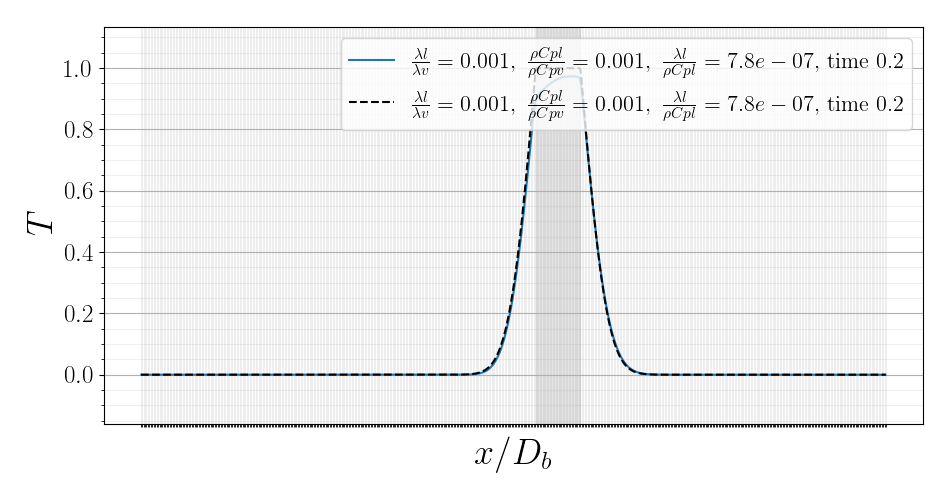

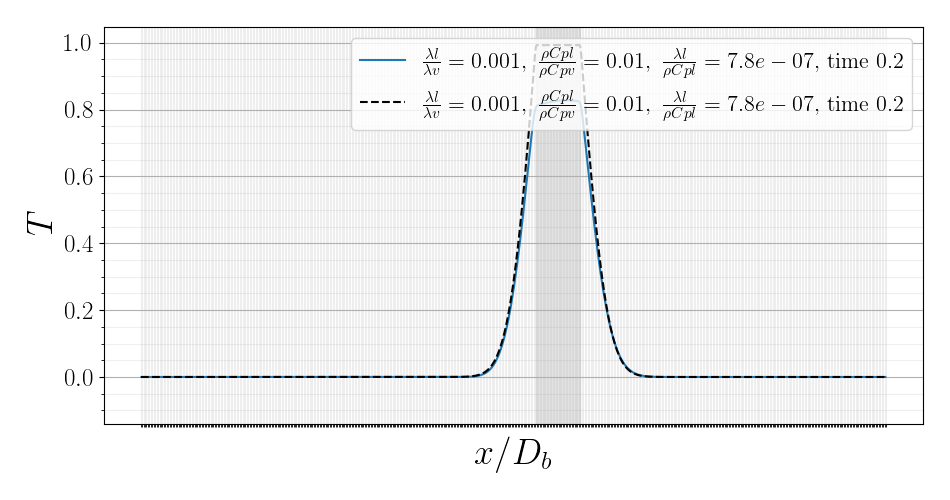

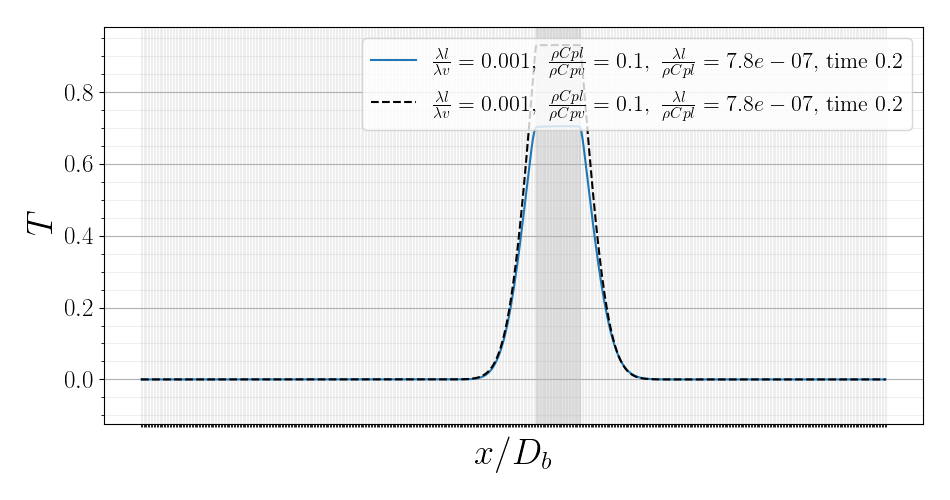

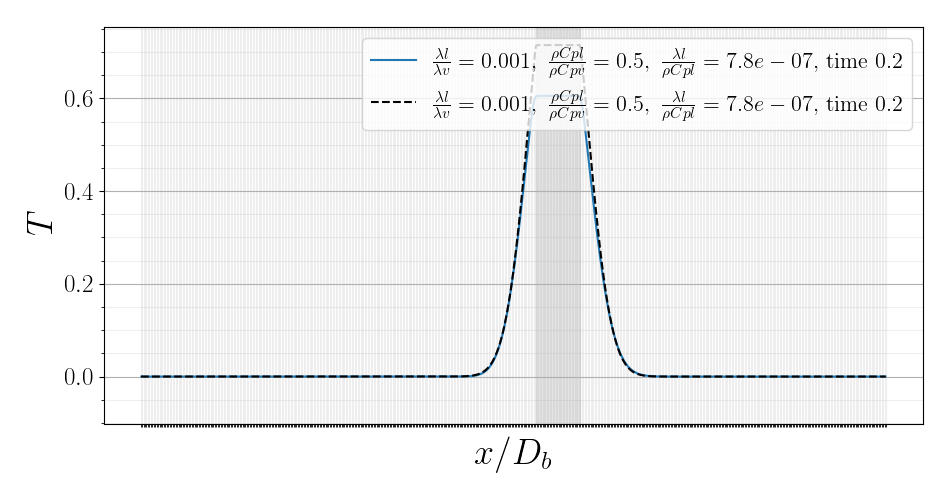

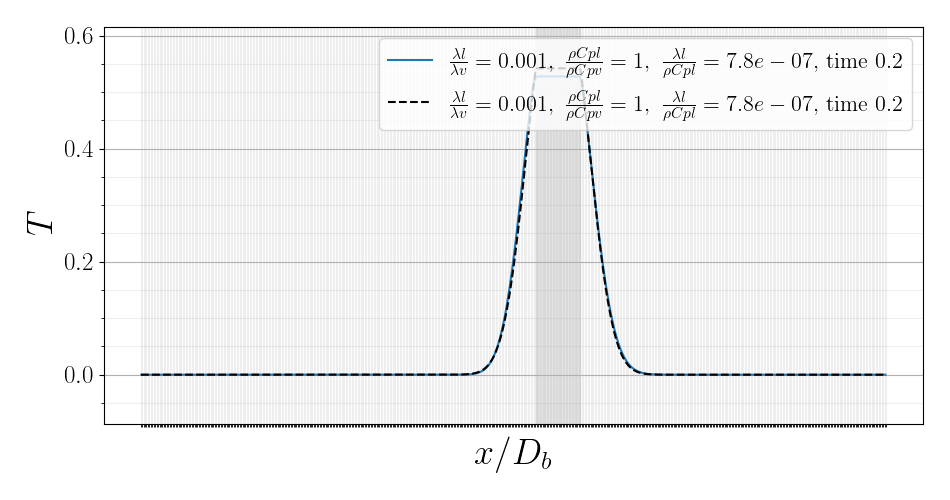

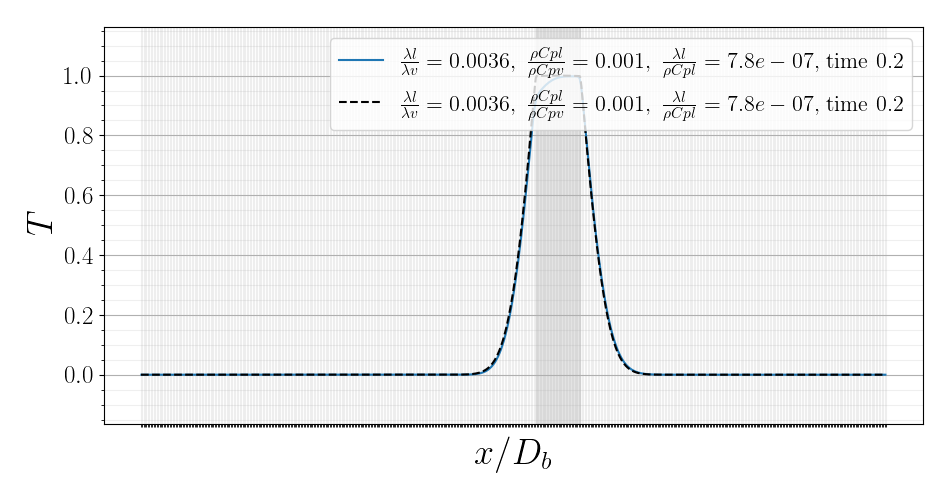

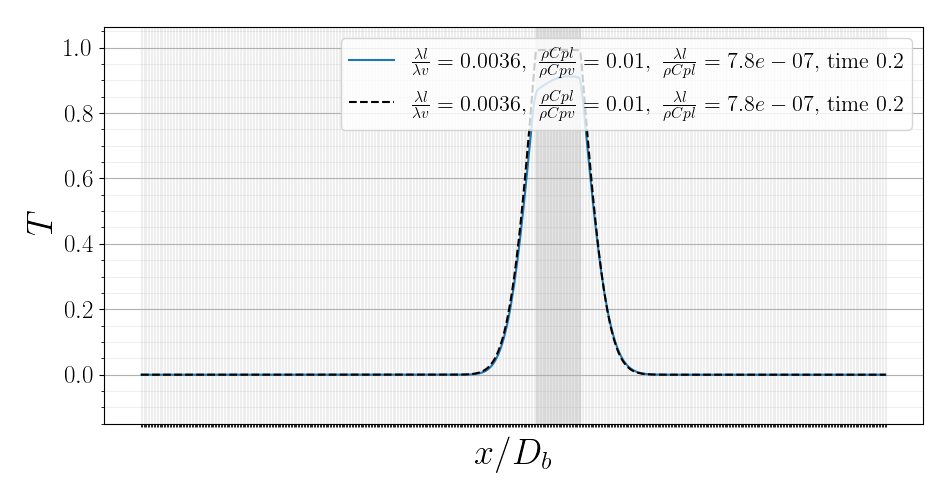

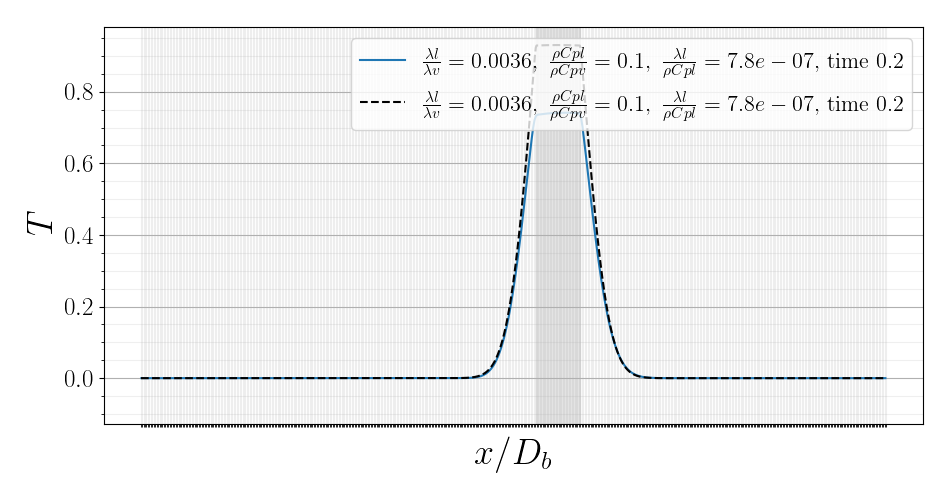

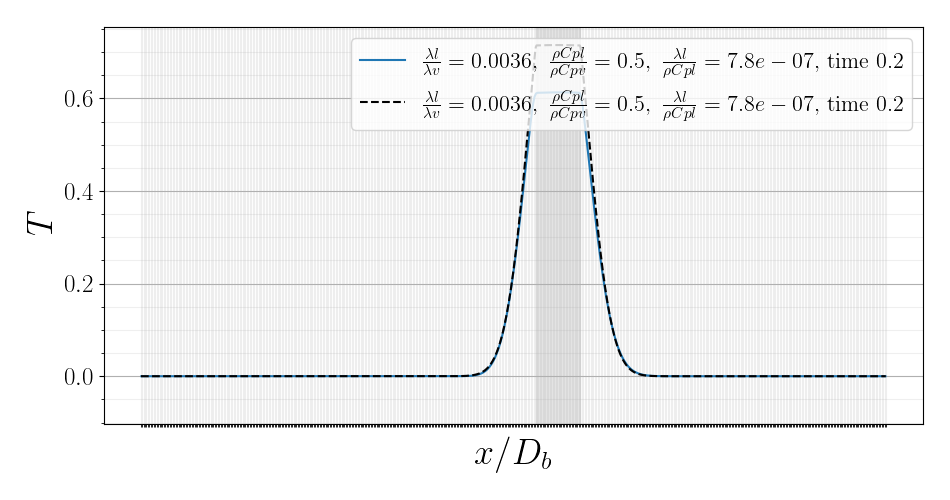

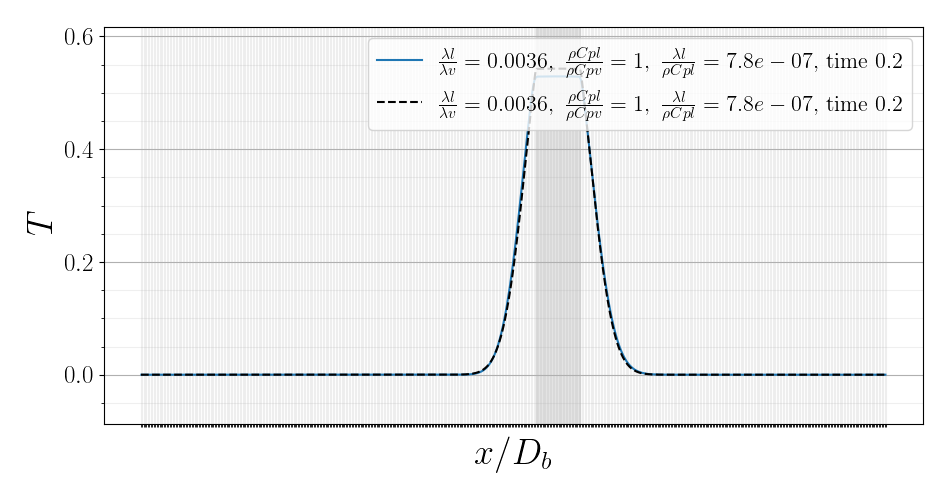

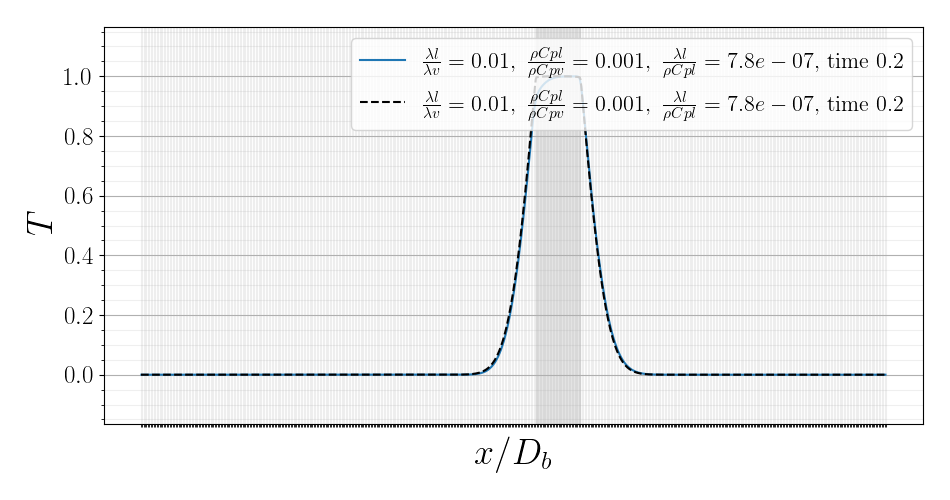

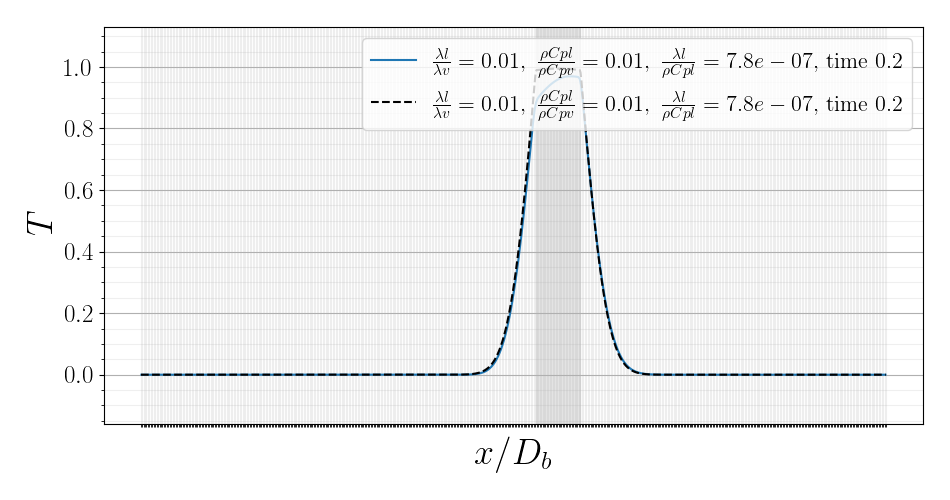

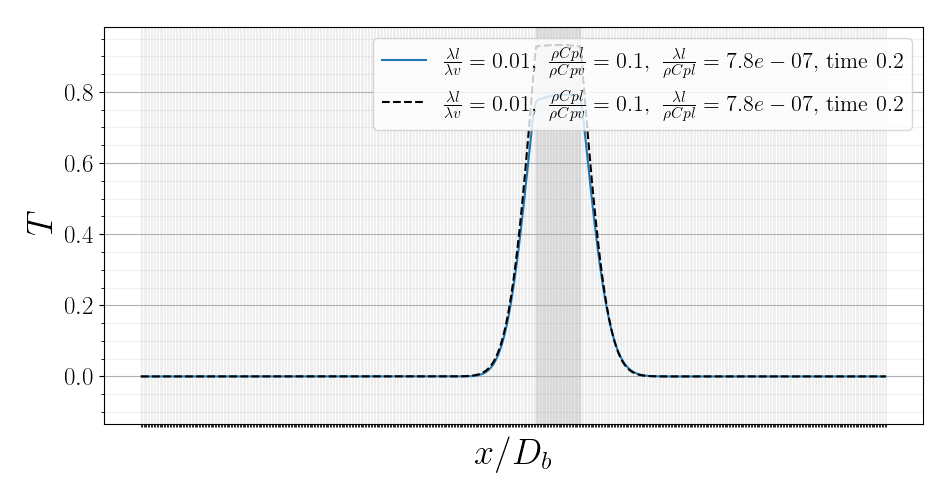

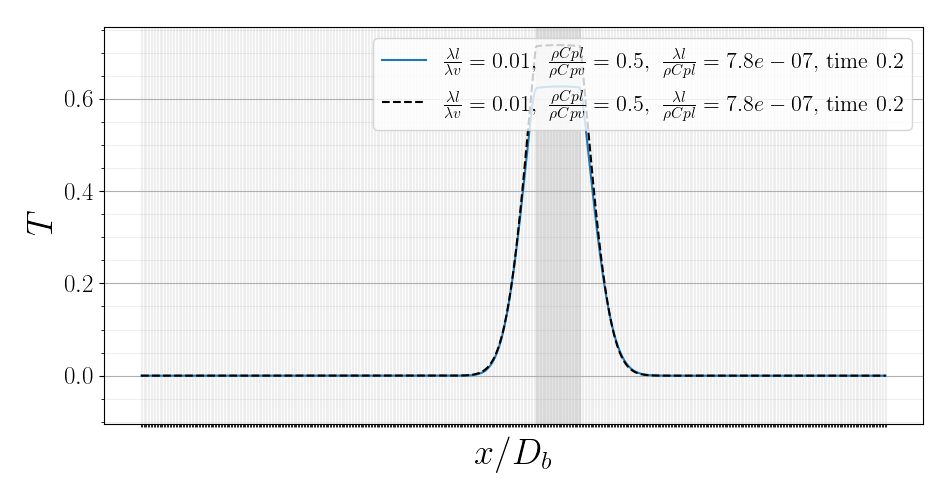

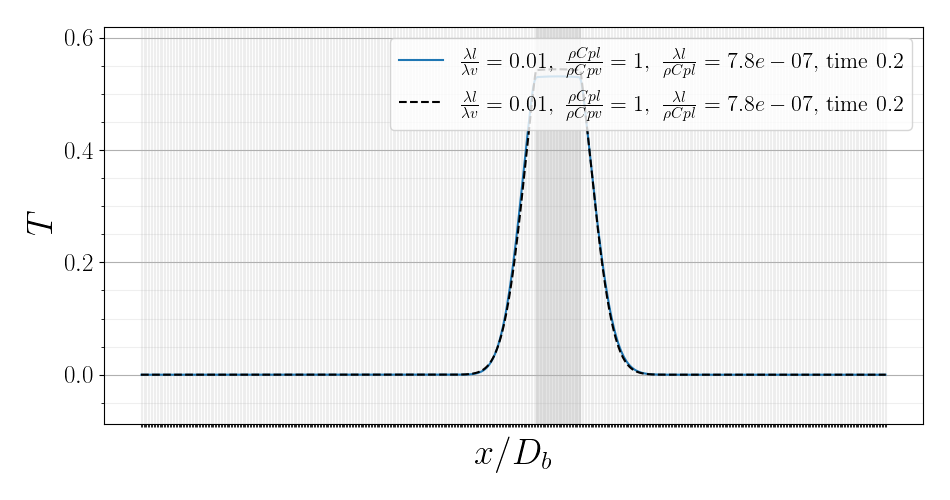

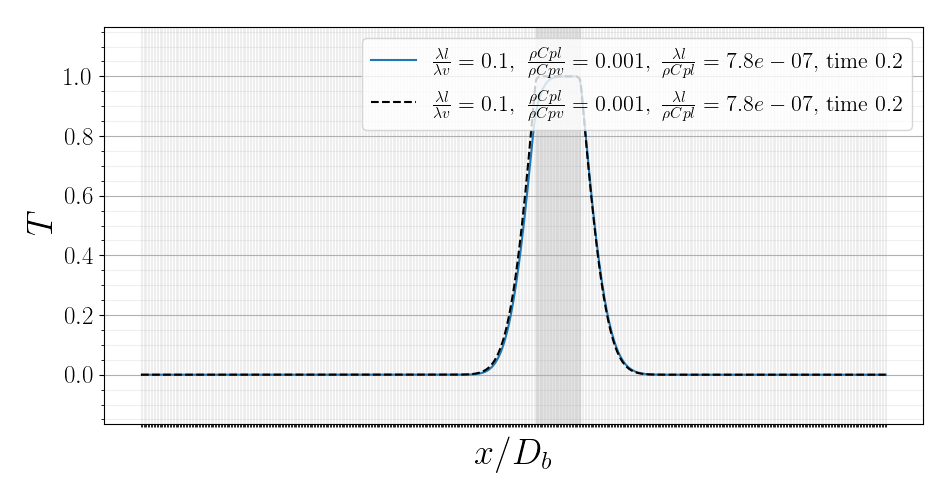

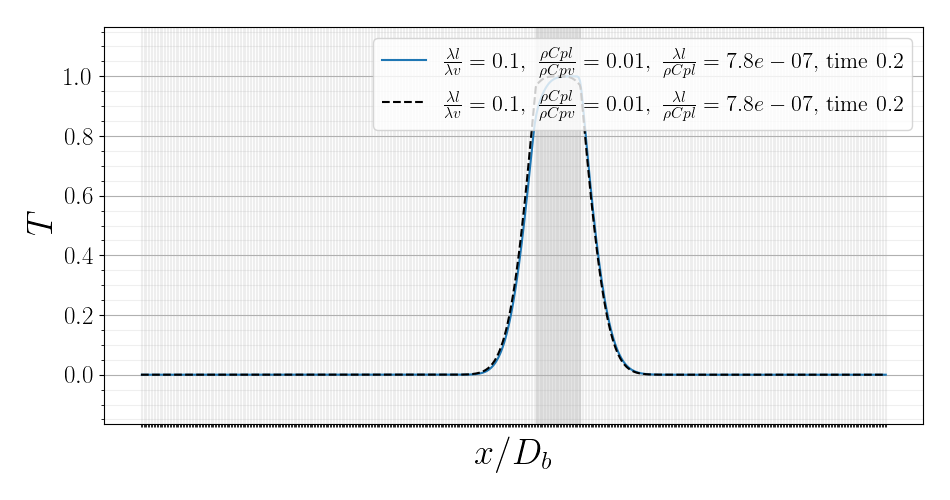

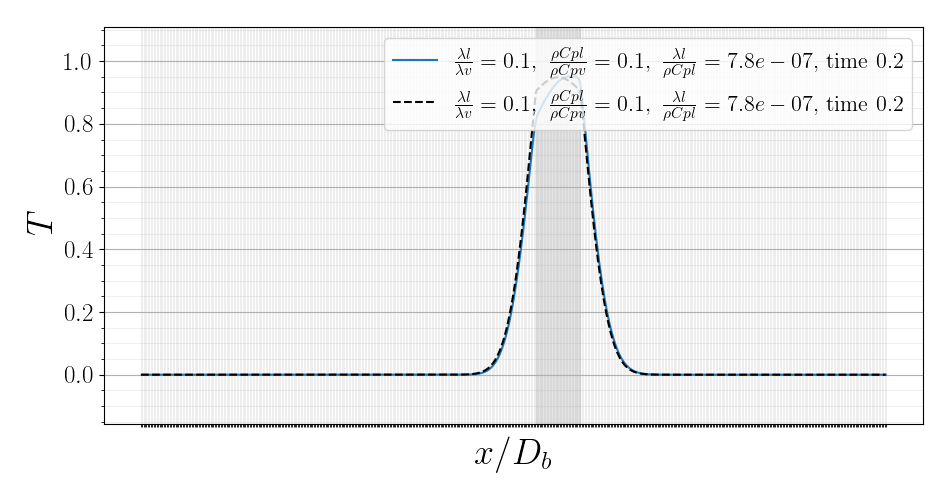

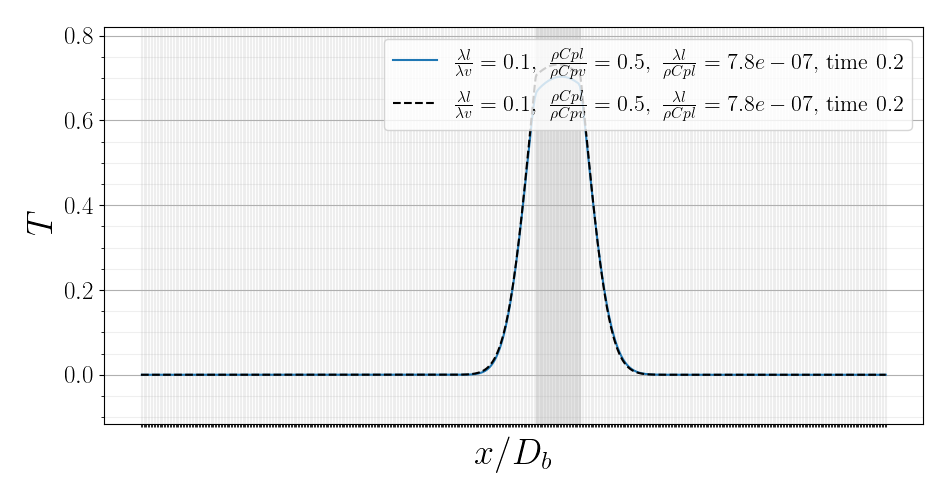

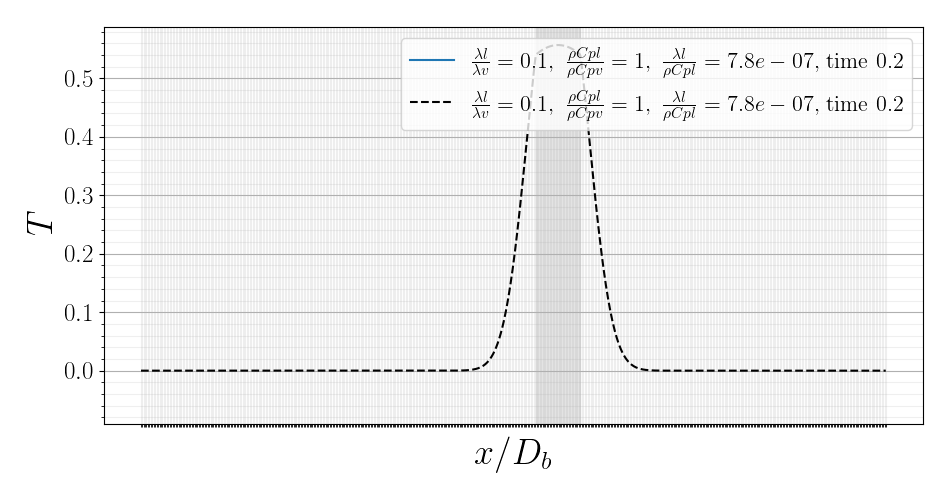

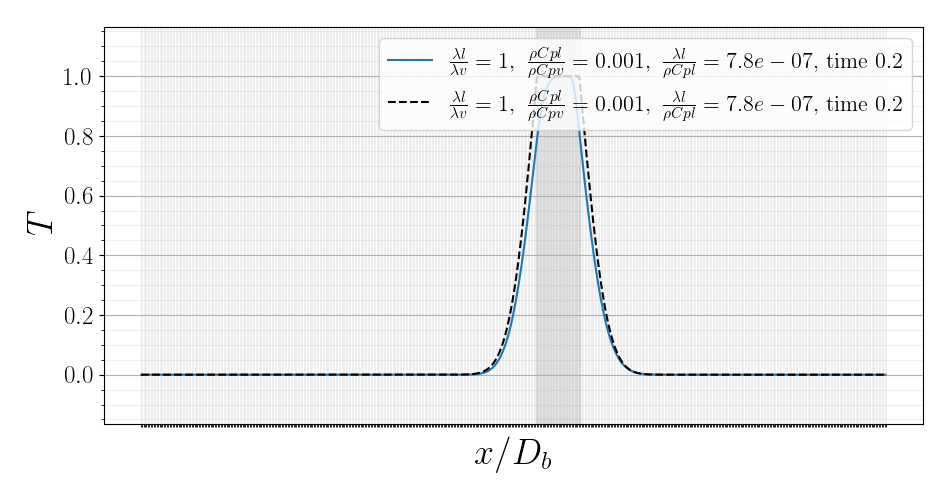

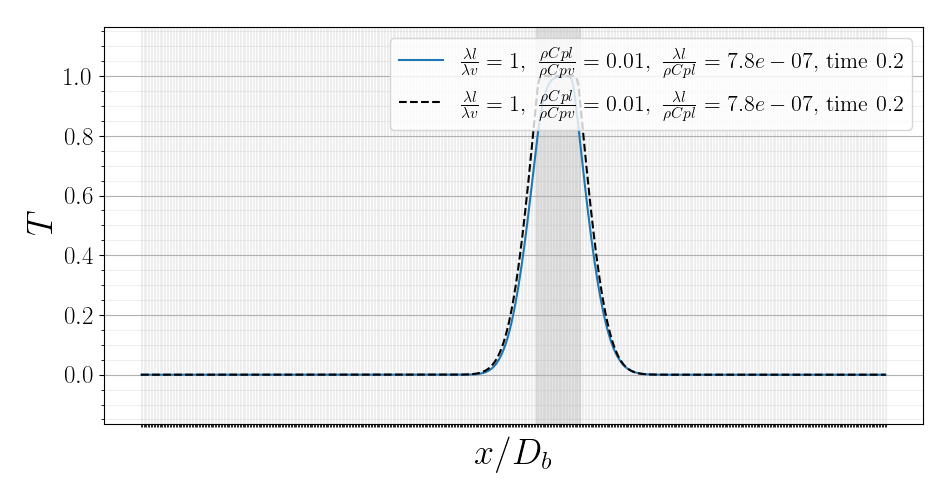

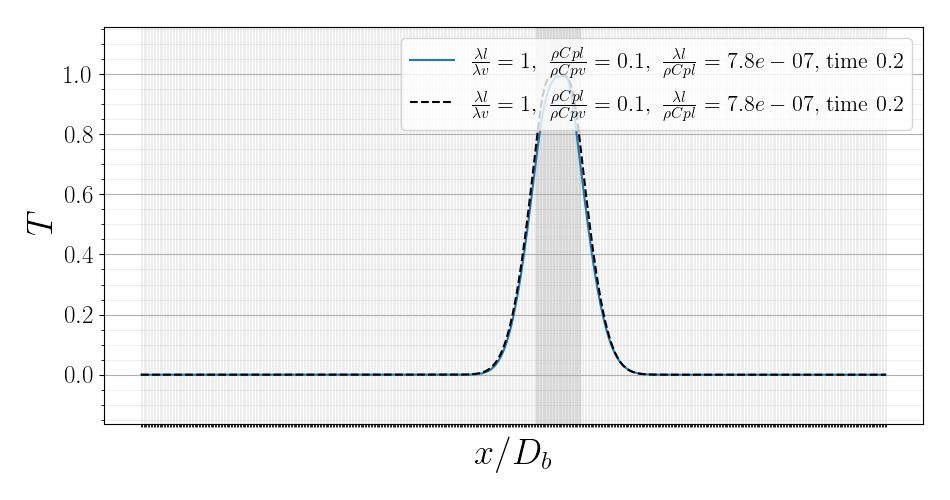

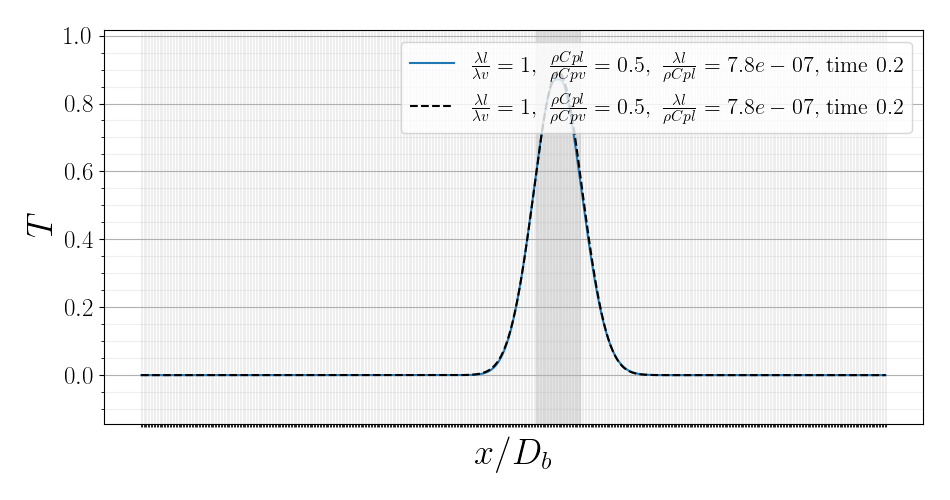

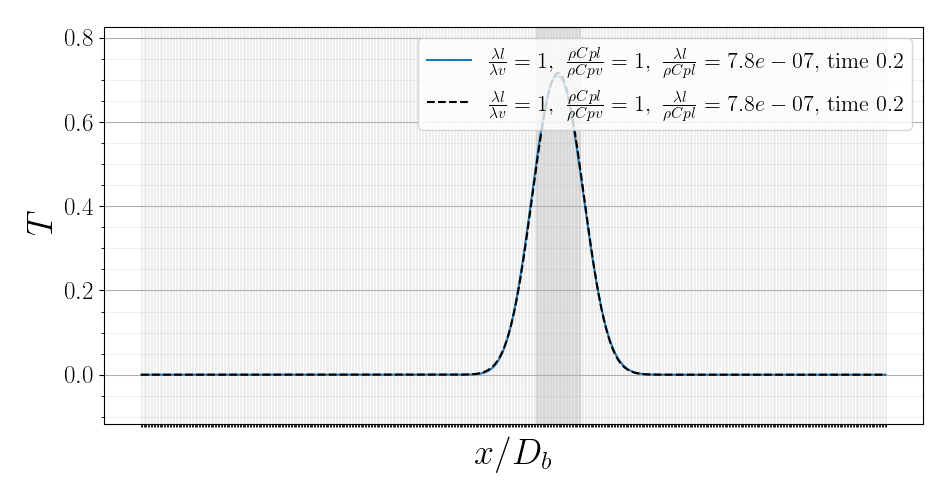

In [8]:
pb_list_tot = list(map(compute_for_rapp, prod_tot))

## Visualisation des pertes d'énergie

In [9]:
param_table = np.array(list(itertools.product(rapp_lda, rapp_rhocp, [1.0]))).T
pb_array = np.array(pb_list_tot)
print(param_table)

[[0.001   0.001   0.001   0.001   0.001   0.00355 0.00355 0.00355 0.00355
  0.00355 0.01    0.01    0.01    0.01    0.01    0.1     0.1     0.1
  0.1     0.1     1.      1.      1.      1.      1.     ]
 [0.001   0.01    0.1     0.5     1.      0.001   0.01    0.1     0.5
  1.      0.001   0.01    0.1     0.5     1.      0.001   0.01    0.1
  0.5     1.      0.001   0.01    0.1     0.5     1.     ]
 [1.      1.      1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      1.      1.      1.      1.     ]]


In [10]:
@np.vectorize
def get_dE(pb):
    e = pb.E
    return np.abs(e[-1] - e[0]) / e[0] * 100

en_array = get_dE(pb_array)
shaped_params = param_table[:-1].T.reshape(len(rapp_lda),len(rapp_rhocp),2)
shaped_en_array = en_array[:,0].reshape(len(rapp_lda), len(rapp_rhocp))
err = (shaped_params[:,:,0] == 0.1) & (shaped_params[:,:,1] == 1.)
shaped_en_array[err] = 0.
print(shaped_params)
print(shaped_en_array)

[[[0.001   0.001  ]
  [0.001   0.01   ]
  [0.001   0.1    ]
  [0.001   0.5    ]
  [0.001   1.     ]]

 [[0.00355 0.001  ]
  [0.00355 0.01   ]
  [0.00355 0.1    ]
  [0.00355 0.5    ]
  [0.00355 1.     ]]

 [[0.01    0.001  ]
  [0.01    0.01   ]
  [0.01    0.1    ]
  [0.01    0.5    ]
  [0.01    1.     ]]

 [[0.1     0.001  ]
  [0.1     0.01   ]
  [0.1     0.1    ]
  [0.1     0.5    ]
  [0.1     1.     ]]

 [[1.      0.001  ]
  [1.      0.01   ]
  [1.      0.1    ]
  [1.      0.5    ]
  [1.      1.     ]]]
[[4.53028369e+00 1.70484290e+01 2.36603694e+01 1.30558945e+01
  1.48102406e-13]
 [1.76888869e+00 9.36465209e+00 1.98848745e+01 1.21776114e+01
  1.64558228e-14]
 [1.17594175e+00 4.48696468e+00 1.48772130e+01 1.06567392e+01
  1.64558228e-14]
 [1.65851240e+00 1.62857809e+00 1.87037832e+00 3.36237081e+00
  0.00000000e+00]
 [5.26639898e+00 5.11138431e+00 3.99057678e+00 1.54278982e+00
  0.00000000e+00]]


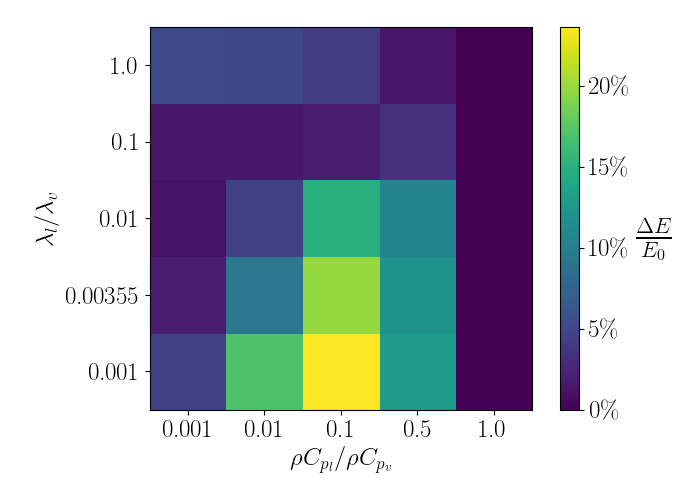

In [35]:
fig, ax = plt.subplots(1)
fig.set_size_inches((7,5))
cax = ax.imshow(shaped_en_array, origin='lower')
cbar = fig.colorbar(cax, format=r'$%g \%%$')
cbar.ax.set_ylabel(r'$\qquad\frac{\Delta E}{E_0}$', rotation='horizontal', horizontalalignment='left', fontsize=23)
fig.canvas.draw_idle()
# cbar.ax.canvas.draw_idle()

ax.set_xticks([i for i in range(len(rapp_rhocp))])
ax.set_xticklabels(rapp_rhocp)
ax.set_xlabel(r'$\rho C_{p_l} / \rho C_{p_v}$')

ax.set_yticks([i for i in range(len(rapp_lda))])
ax.set_yticklabels(rapp_lda)
ax.set_ylabel(r'$\lambda_{l} / \lambda_{v}$')

# ticks = list(cbar.ax.get_yticklabels())
# print(ticks)
# ticks = [r'%s ' % (t.get_text(),) for t in ticks]
# print(ticks)
# cbar.ax.set_yticklabels(ticks)
# cbar.ax.set_yticklabels([r'$0\%$', r'$5\%$', r'$10\%$', r'$15\%$', r'$20\%$'])
fig.tight_layout()
if save_fig:
    fig.savefig(savefig_path + 'heatmap_energy_loss.pdf')

## Etudes des comportements observés en $\lambda$

In [12]:
pb_lda = pb_array[param_table[1] == 0.1, 0]
pb_lda_ref = pb_array[param_table[1] == 0.1, 1]

/home/as259691/PycharmProjects/FluidDyn1D/figures/influence_prop/


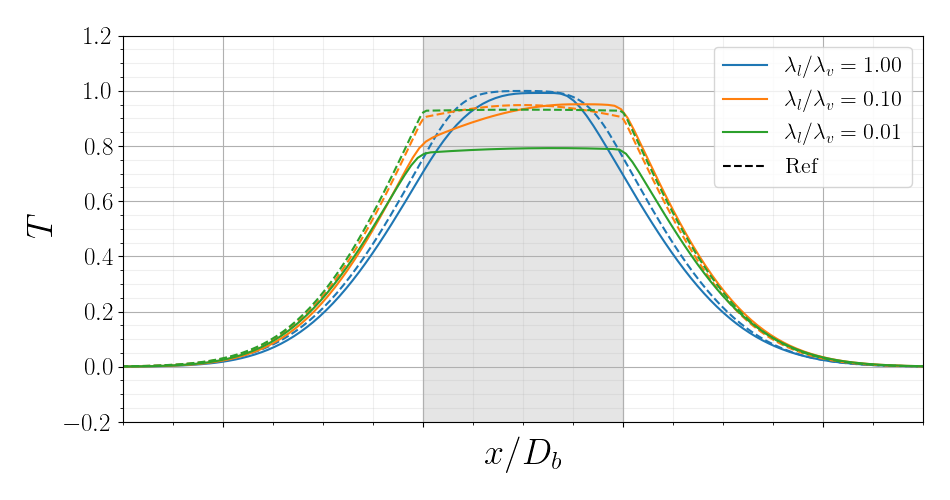

In [13]:
plot_temp_lda = Plotter('decale', ispretty=True, zoom=(-1.5, 2.5))
for i in [2, 3, 4][::-1]:
    pb = pb_lda[i]
    plot_temp_lda.plot(pb, dlabel=r'${\lambda_l}/{\lambda_v} = %.2f$' % (pb.phy_prop.lda1 / pb.phy_prop.lda2))
    c = plot_temp_lda.ax.get_lines()[-1].get_color()
    plot_temp_lda.plot(pb_lda_ref[i], ls='--', c=c, dlabel='')
plot_temp_lda.ax.set_xticklabels([])
plot_temp_lda.ax.plot([], [], 'k--', label='Ref')
plot_temp_lda.ax.legend()
plot_temp_lda.ax.set_ylim(-0.2, 1.2)
plot_temp_lda.fig.tight_layout()
print(savefig_path)
if save_fig:
    plot_temp_lda.fig.savefig(savefig_path + 'temp_f_rapp_lda.pdf')


$\frac{\lambda_l}{\lambda_v} = 0.001,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -6.7172e-07

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -2.07725e-06

$\frac{\lambda_l}{\lambda_v} = 0.01,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -4.56305e-06

$\frac{\lambda_l}{\lambda_v} = 0.1,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -3.1477e-06

$\frac{\lambda_l}{\lambda_v} = 1,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -4.34409e-06


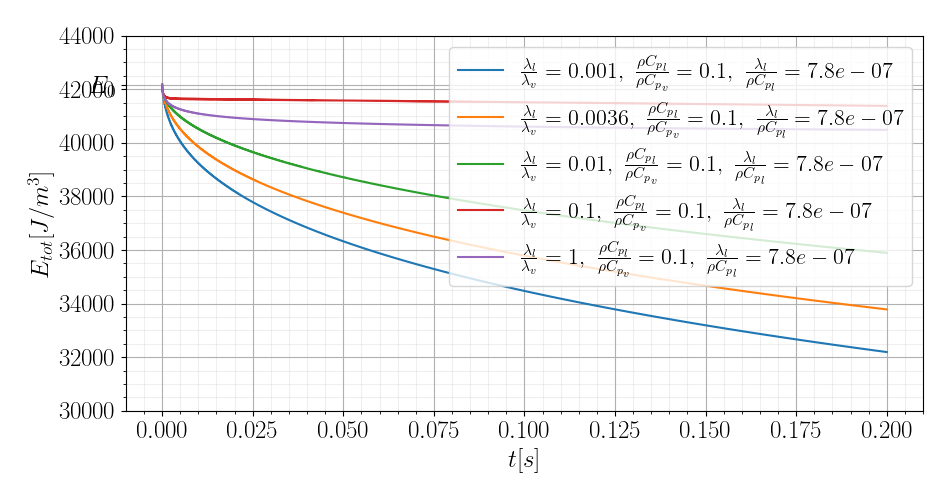

In [14]:
plot_en_lda = EnergiePlot()

for pb in pb_lda:
    plot_en_lda.plot_pb(pb)
plot_en_lda.add_E0()

## Analyse en $\rho C_p$

In [15]:
pb_rhocp = pb_array[param_table[0] == 0.00355, 0]
pb_rhocp_ref = pb_array[param_table[0] == 0.00355, 1]

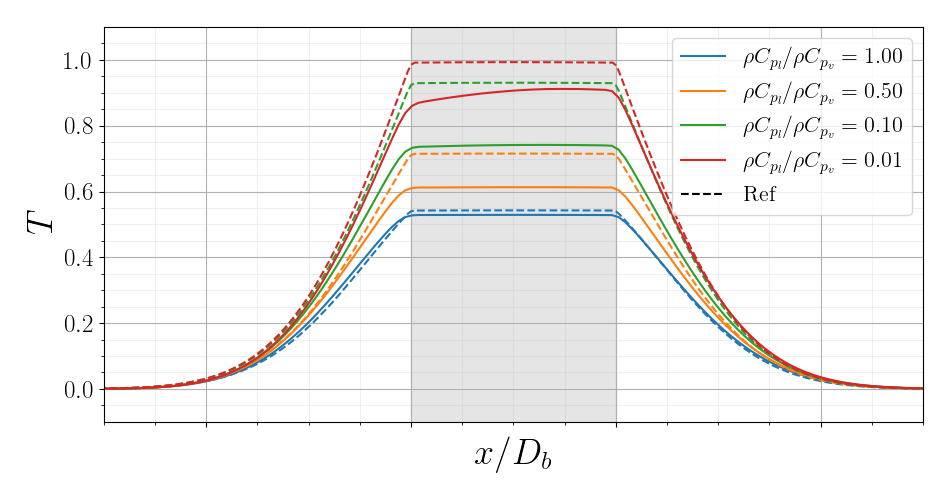

In [16]:
plot_temp_rhocp = Plotter('decale', ispretty=True, zoom=(-1.5,2.5))
for i in [1,2,3,4][::-1]:
    pb = pb_rhocp[i]
    plot_temp_rhocp.plot(pb, dlabel=r'$\rho C_{p_l}/\rho C_{p_v} = %.2f$' % (pb.phy_prop.rho_cp1 / pb.phy_prop.rho_cp2))
    c = plot_temp_rhocp.ax.get_lines()[-1].get_color()
    plot_temp_rhocp.plot(pb_rhocp_ref[i], ls='--', c=c, dlabel='')
plot_temp_rhocp.ax.set_xticklabels([])
plot_temp_rhocp.ax.plot([], [], 'k--', label='Ref')
plot_temp_rhocp.ax.legend()
plot_temp_rhocp.ax.set_ylim(-0.1, 1.1)
plot_temp_rhocp.fig.tight_layout()
if save_fig:
    plot_temp_rhocp.fig.savefig(savefig_path + 'temp_f_rapp_rhocp.pdf')

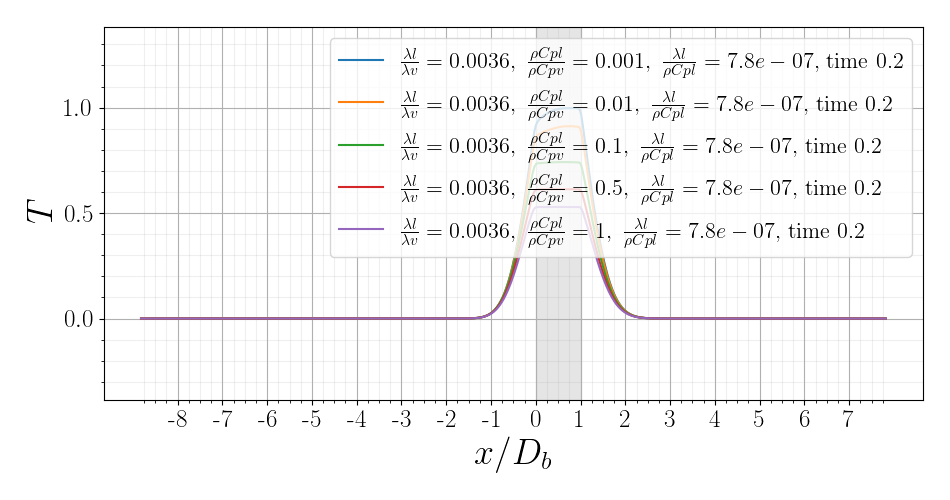

In [17]:
plot_temp_rhocp = Plotter('decale', ispretty=True)

for pb in pb_rhocp:
    plot_temp_rhocp.plot(pb)


$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.001,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -1.00586e-07

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.01,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -1.06364e-06

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -2.07725e-06

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.5,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -1.12403e-06

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -4.85199e-20


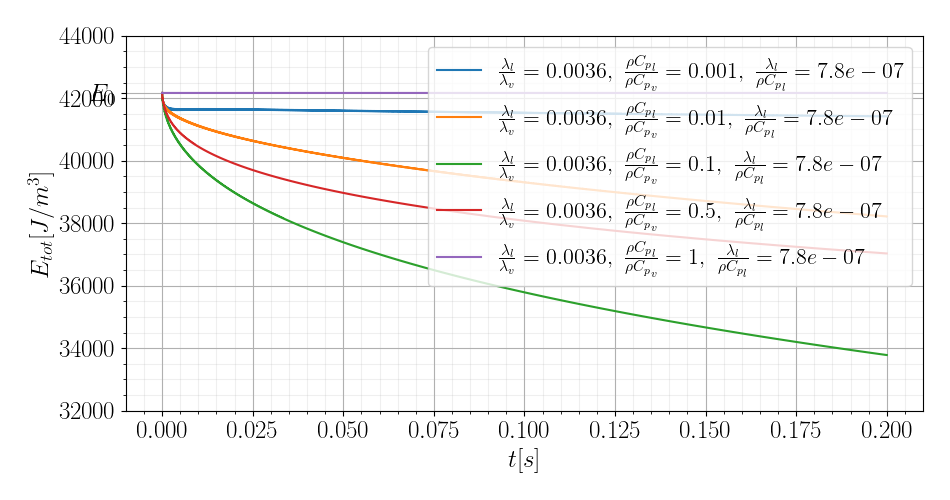

In [18]:
plot_en_rhocp = EnergiePlot()

for pb in pb_rhocp:
    plot_en_rhocp.plot_pb(pb)
plot_en_rhocp.add_E0()

## Étude en $\kappa$

dt fourier
3.4607890735973006e-05
Db / dx = 30
dt fourier
9.090422663996236e-06
Db / dx = 59
References/$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-08$, rk3, quick, dx = 3.90625e-05, dt = 3.5e-05, cfl = 0.177192_t_0.200000.pkl
Db / dx = 30
Reference was loaded
References/$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-08$, rk3, quick, dx = 2.002e-05, dt = 9.1e-06_t_0.200000.pkl
Db / dx = 59
Reference was loaded
dt fourier
6.921578147194603e-06
Db / dx = 30
dt fourier
1.8180845327992476e-06
Db / dx = 59
References/$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 3.9e-07$, rk3, quick, dx = 3.90625e-05, dt = 6.9e-06, cfl = 0.0354385_t_0.200000.pkl
Db / dx = 30
Reference was loaded
References/$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{

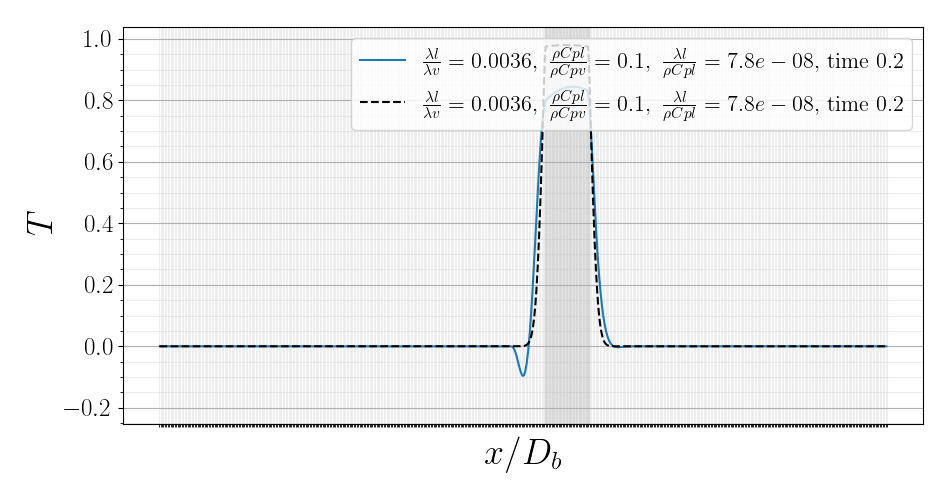

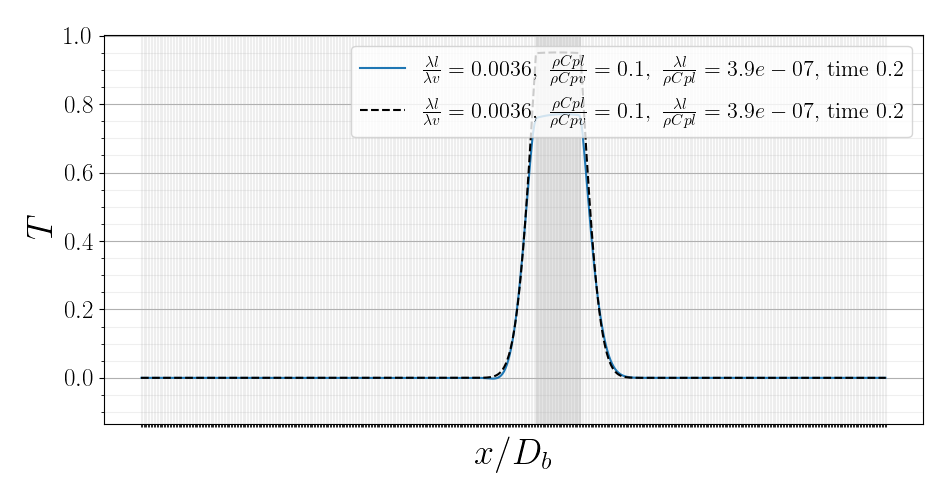

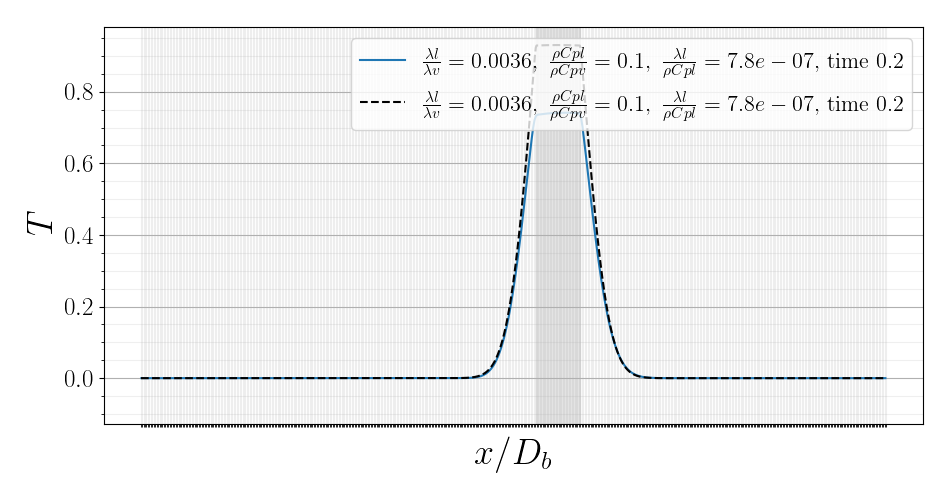

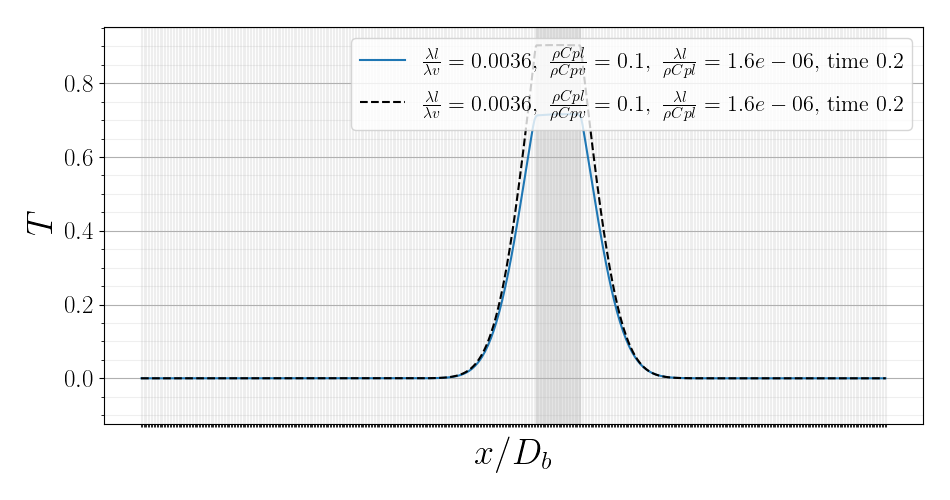

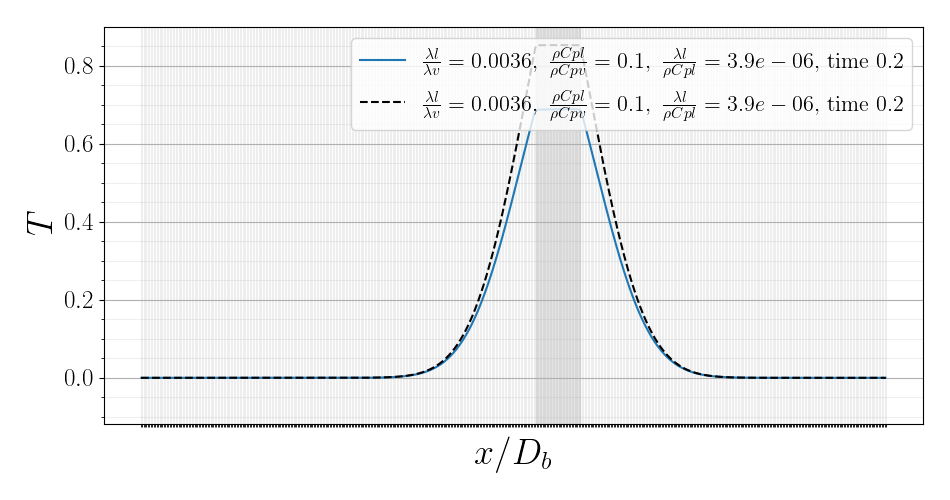

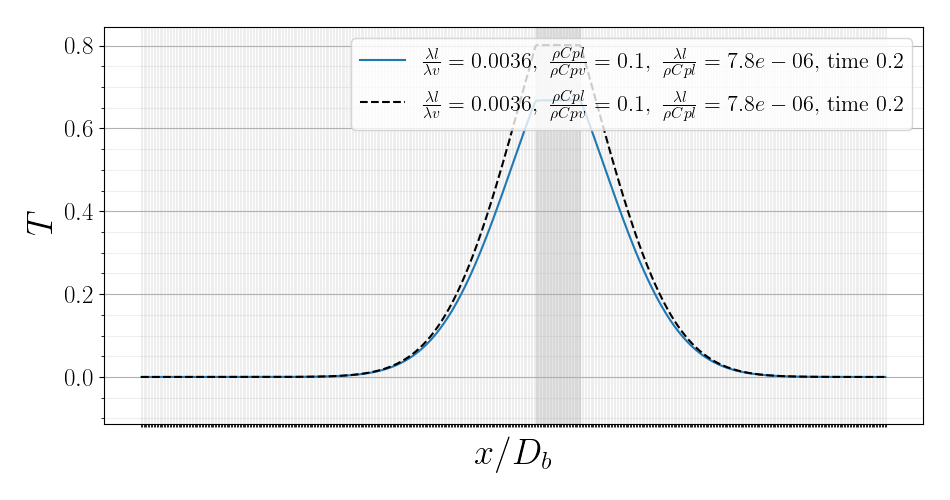

In [19]:
rapp_kappa = [0.1, 0.5, 1.0, 2., 5., 10.0]
prod_kappa = itertools.product([0.00355], [0.1], rapp_kappa)
pb_list_kappa = list(map(compute_for_rapp, prod_kappa))

In [20]:
pb_kappa = [pb[0] for pb in pb_list_kappa]
pb_kappa_ref = [pb[1] for pb in pb_list_kappa]

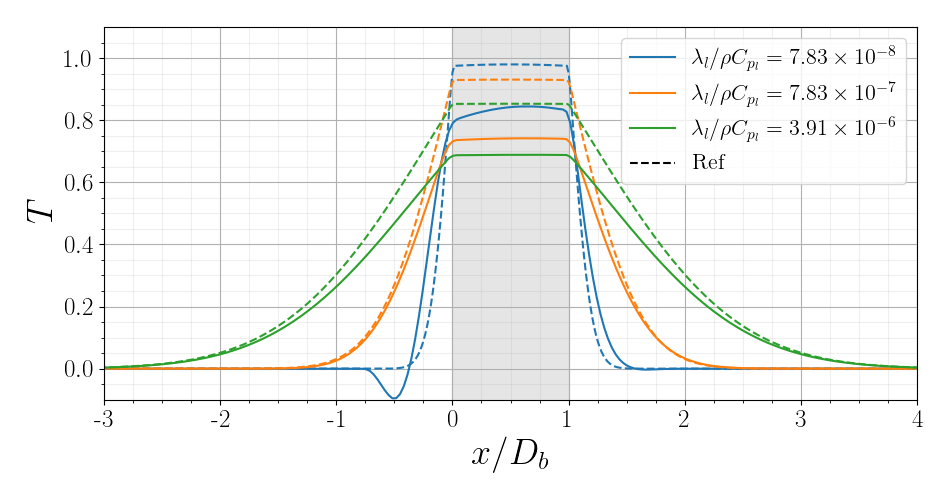

In [21]:
plot_temp_kappa = Plotter('decale', ispretty=True, zoom=(-3,4))
for i in [0,2,4]:
    pb = pb_kappa[i]
    plot_temp_kappa.plot(pb, dlabel=r'$\lambda_l / \rho C_{p_l} = \num{%.2e}$' % (pb.phy_prop.lda1 / pb.phy_prop.rho_cp1))
    c = plot_temp_kappa.ax.get_lines()[-1].get_color()
    plot_temp_kappa.plot(pb_kappa_ref[i], ls='--', c=c, dlabel='')
# plot_temp_kappa.ax.set_xticklabels([])
plot_temp_kappa.ax.plot([], [], 'k--', label='Ref')
plot_temp_kappa.ax.legend()
plot_temp_kappa.ax.set_ylim(-0.1, 1.1)
plot_temp_kappa.fig.tight_layout()
if save_fig:
    plot_temp_kappa.fig.savefig(savefig_path + 'temp_f_rapp_kappa.pdf')


$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-08$
dE*/dt* = -1.47461e-05

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 3.9e-07$
dE*/dt* = -3.83616e-06

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-07$
dE*/dt* = -2.07725e-06

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 1.6e-06$
dE*/dt* = -1.06346e-06

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 3.9e-06$
dE*/dt* = -3.91248e-07

$\frac{\lambda_l}{\lambda_v} = 0.0036,\ \frac{{\rho C_p}_l}{{\rho C_p}_v} = 0.1,\ \frac{\lambda_l}{{\rho C_p}_l} = 7.8e-06$
dE*/dt* = -1.66147e-07


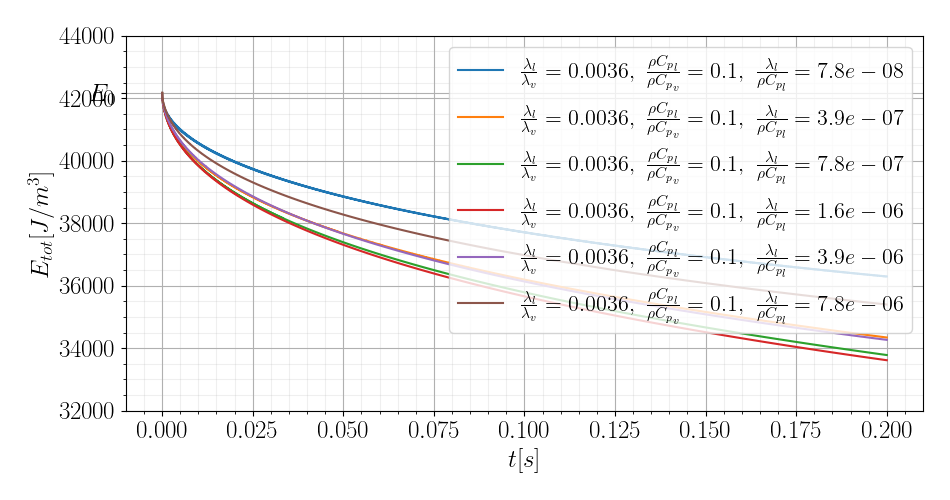

In [22]:
plot_en_kappa = EnergiePlot()

for pb in pb_list_kappa:
    plot_en_kappa.plot_pb(pb[0])
plot_en_kappa.add_E0()

In [37]:
x_kappa = np.array(rapp_kappa)*kappa0
print(x_kappa)
print(kappa0)

[7.82606221e-08 3.91303111e-07 7.82606221e-07 1.56521244e-06
 3.91303111e-06 7.82606221e-06]
7.826062210079968e-07


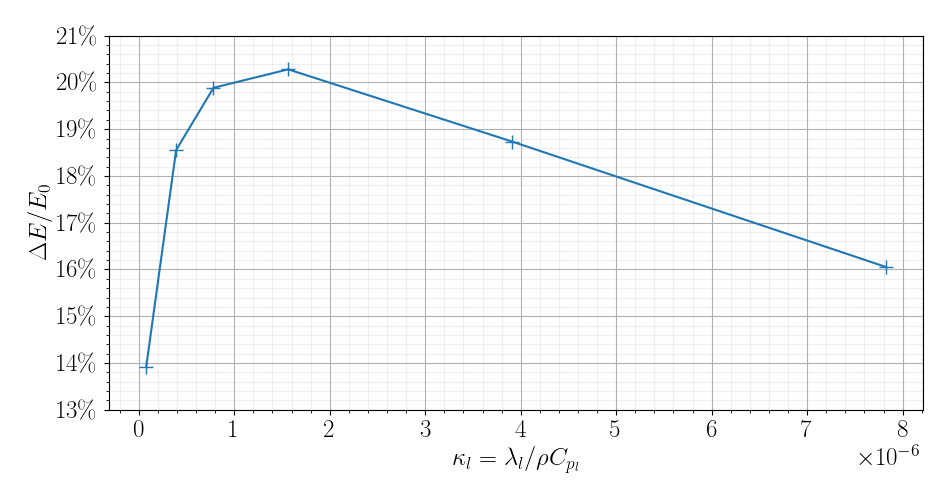

In [23]:
perte_e_kappa = [np.abs(pb.E[-1] - pb.E[0]) / pb.E[0] * 100 for pb in pb_kappa]

perte_plot_kappa = EnergiePlot()
perte_plot_kappa.ax.set_xlabel(r'$\kappa_l = \lambda_l / \rho C_{p_l}$')
perte_plot_kappa.ax.set_ylabel(r'$\Delta E / E_0$')
perte_plot_kappa.ax.plot(np.array(rapp_kappa)*kappa0, perte_e_kappa, '-+', ms=10)
perte_plot_kappa.fig.tight_layout()
perte_plot_kappa.fig.canvas.draw_idle()

tickspos = list(perte_plot_kappa.ax.get_yticks())
tickslabel = [t.get_text() + r'$\%$' for t in perte_plot_kappa.ax.get_yticklabels()]
tickspos = perte_plot_kappa.ax.set_yticks(tickspos)
tickslabel = perte_plot_kappa.ax.set_yticklabels(tickslabel)

perte_plot_kappa.fig.tight_layout()

if save_fig:
    perte_plot_kappa.fig.savefig(savefig_path + 'perte_energie_f_rapp_kappa.pdf')